# Treinamento Rede Siamesa

## Análise do Dataset

O objetivo deste notebook é realizar o treinamento de uma rede Siamesa na tarefa de identificar fraudes em assinaturas. Utilizaremos o dataset [ICDAR2011](http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2011_Signature_Verification_Competition_(SigComp2011)).

Existem 2 pastas: `Testedata_SigComp2011` que correspondem às imagens de teste e `trainingSet` que correspondem às imagens de treinamento. Temos assinaturas no âmbito do Chinês e no âmbito do Alemão

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from itertools import combinations

import random

from tqdm import tqdm # Progress Bar

In [2]:
chinese_training_path = Path("./trainingSet/OfflineSignatures/Chinese/TrainingSet/")

Podemos acessar todos os elementos de cada pasta para as assinaturas genuínas e as forjadas.

In [3]:
genuine = chinese_training_path/"Offline Genuine"
forgeries = chinese_training_path/"Offline Forgeries"

genuine_img_paths = list(genuine.glob("*.png"))
forgeries_img_paths = list(forgeries.glob("*.png"))

genuine_img_paths[:5], forgeries_img_paths[:5]

([WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/001_1.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/001_10.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/001_11.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/001_12.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine/001_13.png')],
 [WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/0100003_1.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/0100003_10.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/0100003_11.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/0100003_12.png'),
  WindowsPath('trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries/0100003_2.png')])

Vamos observar alguns pares de assinaturas. O nome está organizado na seguinte forma:

- Assinaturas Genuínas: III_NN
- Assinaturas Forjadas: FFFFIII_NN

Onde:

- III: ID de referência do autor original da assinatura
- NN: N-ésima contribuição de assinatura do autor III
- FFFF: ID do forjador

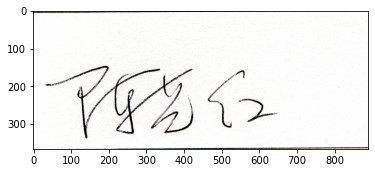

In [4]:
desired_size = (889,366)

img1 = Image.open(genuine_img_paths[0]).resize(desired_size)
img2 = Image.open(forgeries_img_paths[0]).resize(desired_size)

plt.imshow(img1.resize(desired_size))
plt.show()

In [5]:
# Queremos 9 assinaturas reais como base
genuine_filenames = [f"00{i}_1" for i in range(1,10)]
genuine_example_paths = [gim for gim in genuine_img_paths if gim.stem in genuine_filenames]

# Obtemos então uma forja de cada uma
forgeries_example_paths = [random.choice(list(forgeries.glob(f"*0{writer_ID}_*.png"))) for writer_ID in range(1,10)]

A assinatura forjada correspondente está conectada ao índice da lista. Com isso em mãos, podemos plotar alguns exemplos:

In [197]:
desired_size = (889,366) # Apenas para manter a consistência nos tamanhos

def concat_img_v(im1, im2): # Pequena função para concatenar imagens verticalmente
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_img(path, size=desired_size): # Função para abrir a imagem no formato correto
    return Image.open(path, mode="r").resize(size).convert("RGB")

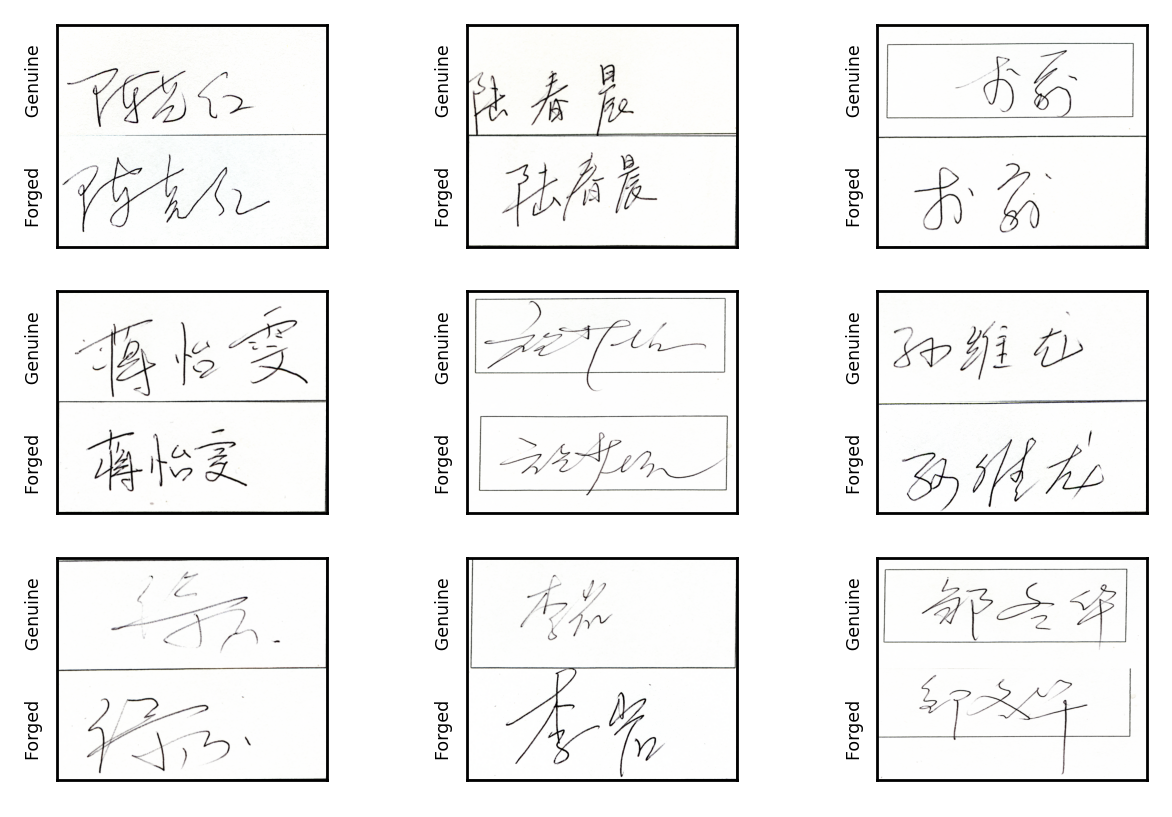

In [7]:
# Criamos um subplot para observar vários exemplos de uma vez
fig, ax = plt.subplots(3, 3, dpi=250)
plt.subplots_adjust(wspace=0.2, hspace=0.2)

i = 0
j = 0

for writerID in range(0,9):
    img1 = get_img(genuine_example_paths[writerID])
    img2 = get_img(forgeries_example_paths[writerID])
    img_concat = concat_img_v(img1, img2)
    if j % 3 == 0 and j != 0:
        j = 0
        i += 1
    ax[i][j].imshow(img_concat)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].set_ylabel("Forged         Genuine", fontsize=5)
    j += 1

Um exemplo de rede siamesa é a seguinte arquitetura:
<center><img src="images/Siamese Network.png"></center>

Uma rede neural siamesa é uma classe de redes neurais que contém duas ou mais redes idênticas. Idênticas aqui significa que sua arquitetura e pesos são exatamente iguais. É utilizada para encontrar a similaridade entre as entradas comparando seu vetor de features de saída.

Com essa configuração, podemos usar uma `Pairwise Ranking Loss` ou `Contrastive Loss` para treinar a rede. Ela é definida como:

\begin{equation}
loss(d,Y) = \frac{1}{2}\times Y\times d^2+(1-Y)\times \frac{1}{2}\times max(0, m-d)^2
\end{equation}

Essa é uma função de custo baseada em distância com apenas 2 termos. 
- `Y` é a label do objeto. Quando os objetos são similares, `Y = 1`. Qiando os objetos são diferentes, `Y = 0`.
- `d` é a distância entre os vetores de features na saída.
- `m` é o parâmetro de margem.

Com essa função, tornamos a rede capaz de aprender embeddings nos quais dois pontos similares possuem uma baixa distância euclidiana e dois pontos muito diferentes possuem uma distância euclidiana alta. Podemos defini-la da seguinte maneira abaixo:

In [8]:
class ContrastiveLoss(nn.Module): # Devemos herdar a classe Module para que o PyTorch consiga compatibilidade total nos métodos de treinamento
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, dist, label):

        loss = torch.mean(1/2*label * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2), axis=0)


        return loss

Testando...

In [9]:
cont_loss = ContrastiveLoss()

In [10]:
a = torch.FloatTensor([[3, 4, 0], [3, 4, 0], [3, 4, 0]])
b = torch.FloatTensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

dist = torch.cdist(a, b)
a.shape, b.shape, dist, cont_loss(dist, 1)

(torch.Size([3, 3]),
 torch.Size([3, 3]),
 tensor([[5., 5., 5.],
         [5., 5., 5.],
         [5., 5., 5.]]),
 tensor([12.5000, 12.5000, 12.5000]))

## Criação do Dataset em Pytorch

Tudo certo, podemos agora definir o nosso dataset. Para isso, devemos considerar como as imagens devem ser obtidas nos pares. 

- Cada amostra de assinatura GENUÍNA de um mesmo autor deve ser comparada com as suas outras amostras GENUÍNAS uma única vez.
- Cada amostra de assinatura FORJADA de um mesmo forjador deve ser comparada com as amostras FORJADAS do mesmo forjador respectivas ao mesmo autor uma única vez.
- Cada amostra de assinatura GENUÍNA de um mesmo autor deve ser comparada com as amostras FORJADAS para o mesmo autor uma única vez.

In [11]:
class ConstrastiveICDARDataset(Dataset):
    
    def __init__(self, transform=None):
        training_path = Path("./trainingSet/OfflineSignatures/")
        
        chinese_genuine = training_path/"Chinese"/"TrainingSet"/"Offline Genuine"
        chinese_forgeries = training_path/"Chinese"/"TrainingSet"/"Offline Forgeries"
        
        chinese_genuine_img_paths = list(chinese_genuine.glob("*.png"))
        chinese_forgeries_img_paths = list(chinese_forgeries.glob("*.png"))
        
        dutch_genuine = training_path/"Dutch"/"TrainingSet"/"Offline Genuine"
        dutch_forgeries = training_path/"Dutch"/"TrainingSet"/"Offline Forgeries"

        dutch_genuine_img_paths = list(dutch_genuine.glob("*.png"))
        dutch_forgeries_img_paths = list(dutch_forgeries.glob("*.png"))
        
        # Author Combs
        available_chinese_authors = set([genuine_img_path.stem.split("_")[0] for genuine_img_path in chinese_genuine_img_paths])
        available_dutch_authors = set([genuine_img_path.stem.split("_")[0] for genuine_img_path in dutch_genuine_img_paths])
        self.combs = []
        aux_combs1 = []
        aux_combs2 = []
        for available_author in available_chinese_authors: # Chinese
            available_author_signatures = [genuine_img_path
                                           for genuine_img_path in chinese_genuine_img_paths 
                                           if genuine_img_path.stem.split("_")[0] == available_author]
            aux_combs1.extend(list(combinations(available_author_signatures, 2)))
            aux_combs2 = [list(comb) + [1] for comb in aux_combs1] # Colocamos a Label aqui (Similares Y = 1)
        
        self.combs.extend(aux_combs2)
        aux_combs1 = []
        aux_combs2 = []
        for available_author in available_dutch_authors: # Dutch
            available_author_signatures = [genuine_img_path
                                           for genuine_img_path in dutch_genuine_img_paths 
                                           if genuine_img_path.stem.split("_")[0] == available_author]
            aux_combs1.extend(list(combinations(available_author_signatures, 2)))
            aux_combs2 = [list(comb) + [1] for comb in aux_combs1] # Colocamos a Label aqui (Similares Y = 1)
            
        self.combs.extend(aux_combs2)
        aux_combs1 = []
        aux_combs2 = []
        
        # Forger Combs
        available_chinese_forgers = set([genuine_img_path.stem.split("_")[0][:-3] for genuine_img_path in chinese_forgeries_img_paths])
        available_dutch_forgers = set([genuine_img_path.stem.split("_")[0] for genuine_img_path in dutch_forgeries_img_paths])
        for available_author in available_chinese_authors:
            for available_forger in available_chinese_forgers:
                available_forged_signatures = [forged_img_path for forged_img_path in chinese_forgeries_img_paths 
                                               if (forged_img_path.stem.split("_")[0][-3:] == available_author) 
                                               and (forged_img_path.stem.split("_")[0][:-3] == available_forger)]
                aux_combs1.extend(list(combinations(available_forged_signatures, 2)))
                aux_combs2 = [list(comb) + [1] for comb in aux_combs1] # Colocamos a Label aqui (Similares Y = 1)

        self.combs.extend(aux_combs2)
        aux_combs1 = []
        aux_combs2 = []
        for available_author in available_dutch_authors:
            for available_forger in available_dutch_forgers:
                available_forged_signatures = [forged_img_path for forged_img_path in dutch_forgeries_img_paths 
                                               if (forged_img_path.stem.split("_")[0][-3:] == available_author) 
                                               and (forged_img_path.stem.split("_")[0][:-3] == available_forger)]
                aux_combs1.extend(list(combinations(available_forged_signatures, 2)))
                aux_combs2 = [list(comb) + [1] for comb in aux_combs1] # Colocamos a Label aqui (Similares Y = 1)
   
        self.combs.extend(aux_combs2)
        aux_combs1 = []
        aux_combs2 = []
        
        # Author-Forger combs
        for available_author in available_chinese_authors: # Chinese
            available_genuine_signatures = [genuine_img_path for genuine_img_path in chinese_genuine_img_paths 
                                            if genuine_img_path.stem.split("_")[0][-3:] == available_author]

            available_forged_signatures = [forged_img_path for forged_img_path in chinese_forgeries_img_paths 
                                           if forged_img_path.stem.split("_")[0][-3:] == available_author]

            for available_genuine_signature in available_genuine_signatures:
                for available_forged_signature in available_forged_signatures:
                    self.combs.append([available_genuine_signature, available_forged_signature, 0])  # Colocamos a Label aqui (Diferentes Y = 0)
                   
                
        # Author-Forger combs
        for available_author in available_dutch_authors: # Dutch
            available_genuine_signatures = [genuine_img_path for genuine_img_path in dutch_genuine_img_paths 
                                            if genuine_img_path.stem.split("_")[0][-3:] == available_author]

            available_forged_signatures = [forged_img_path for forged_img_path in dutch_forgeries_img_paths 
                                           if forged_img_path.stem.split("_")[0][-3:] == available_author]

            for available_genuine_signature in available_genuine_signatures:
                for available_forged_signature in available_forged_signatures:
                    self.combs.append([available_genuine_signature, available_forged_signature, 0])  # Colocamos a Label aqui (Diferentes Y = 0)
                    
        self.transform = transform
        
    def __len__(self):
        return len(self.combs)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img1 = Image.open(self.combs[idx][0])
        img2 = Image.open(self.combs[idx][1])

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return (img1, img2, torch.tensor(self.combs[idx][2], dtype=torch.float32))

Agora instanciamos nosso dataset, passando as transformações necessárias para ser futuramente alimentado na rede.

In [12]:
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               #                     std=[0.229, 0.224, 0.225]) # Normalização ImageNet, não manterei neste caso pois as cores se resumem a preto e branco, isso não acarretará problemas para a rede.
                               ])

dataset = ConstrastiveICDARDataset(transform=transform)
len(dataset)

18139

Temos um total de 18 mil combinações par a par. Verificamos agora as imagens e se tudo está sendo entregue corretamente:

Genuine


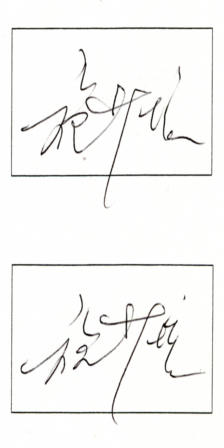

In [13]:
data = dataset[300]
print({1: "Genuine", 0: "Forged"}[int(data[2])])
concat_img_v(transforms.functional.to_pil_image(data[0]), transforms.functional.to_pil_image(data[1]))

## Definição da Arquitetura

Utilizarei uma rede `Resnet18` pré treinada.

In [14]:
model = models.resnet18(pretrained=True, progress=True)

Porém, para o dataset em questão, não podemos utilizá-la da forma atual. Como estamos interessados apenas no vetor de features final, precisamos nos livrar da última camada classificadora.

In [15]:
class Identity(nn.Module): # Uma camada que não faz nada, agindo apenas como identidade
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model.fc = Identity()

Agora verificamos a saída da rede com uma imagem de entrada.

In [16]:
test_img = dataset[0][0]
with torch.no_grad():
    output = model(test_img.unsqueeze(0))
output.shape, output[0, :20]

(torch.Size([1, 512]),
 tensor([0.9462, 0.9221, 0.8934, 1.0713, 0.8991, 0.8307, 0.9644, 1.1440, 0.8846,
         0.9627, 0.8489, 0.8140, 0.9508, 0.8808, 0.8638, 0.8563, 0.9161, 1.2316,
         0.8177, 0.7980]))

Tudo parece estar correto! Vamos criar um novo modelo que utilizará o modelo `Resnet18` modificado de forma que seu método `forward()` seja um de passagem dupla.

In [17]:
class SiameseResnet(nn.Module):
    
    def __init__(self, model):
        super(SiameseResnet, self).__init__()
        self.baseModel = model    
    
    def forward_once(self, x):
        out = self.baseModel(x)
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.baseModel(x2)
        out = nn.functional.pairwise_distance(out1, out2).unsqueeze(0)
        return out

Agora instanciamos o modelo e verificamos seu correto funcionamento:

In [18]:
siam_model = SiameseResnet(model)

img1 = dataset[0][0].unsqueeze(0)
img2 = dataset[0][1].unsqueeze(0)

with torch.no_grad():
    output = siam_model(img1, img2)
    
output.shape, output

(torch.Size([1, 1]), tensor([[1.3388]]))

Funcionando perfeitamente. Agora vamos verificar o funcionamento para um `batch_size` maior que um.

In [19]:
img_batch1 = torch.cat((dataset[0][0].unsqueeze(0), dataset[3000][0].unsqueeze(0), dataset[8500][0].unsqueeze(0)), axis=0) # BS=3
img_batch2 = torch.cat((dataset[0][1].unsqueeze(0), dataset[3000][1].unsqueeze(0), dataset[8500][1].unsqueeze(0)), axis=0)

with torch.no_grad():
    output = siam_model(img_batch1, img_batch2)
    
with torch.no_grad():
    print(cont_loss(output.unsqueeze(0), torch.cat((dataset[0][2].unsqueeze(0), dataset[3000][2].unsqueeze(0), dataset[8500][2].unsqueeze(0)), axis=0)))
    
output.shape, output

tensor([[71.0833, 77.2503,  0.0000]])


(torch.Size([1, 3]), tensor([[11.9234, 12.4298, 12.9084]]))

Tudo funcionando perfeitamente também. Seguimos em frente, criando os `DataLoaders`.

## Dataloaders

Vamos agora criar os objetos que cuidaram de buscar "pedaços" do dataset de tamanho específico determinado.

In [20]:
from torch.utils.data import DataLoader, SubsetRandomSampler

batch_size = 80
pct_for_training = 0.7

shuffled_idxs = torch.randperm(len(dataset))
train_idxs = shuffled_idxs[:int(0.7*len(shuffled_idxs))]
test_idxs = shuffled_idxs[int(0.7*len(shuffled_idxs)):]

train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_dl = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

Vamos obter uma amostra do dataloader e passar pelo modelo para verificar as corretas dimensionalidades. Vamos também observar se o gradiente foi calculado para uma das camadas da rede.

In [21]:
siam_model.baseModel.layer4[1].conv1.weight.grad

Rodando esse linha inicialmente temos uma saída nula, o que é de se esperar pois nenhum gradiente foi calculado ainda. 
Vamos calcular logo a seguir.
Primeiro uma iteração do dataloader de treinamento.

In [22]:
inputs1, inputs2, targets = next(iter(train_dl))

Em seguida o enviamos à rede porém mantendo visão do gradiente corretamente dessa vez.

In [23]:
out = siam_model(inputs1, inputs2)
out.shape

torch.Size([1, 80])

Podemos agora calcular o custo.

In [24]:
loss = cont_loss(out, targets)

loss.shape, loss

(torch.Size([80]),
 tensor([136.7020,  77.3315,   0.0000,   0.0000,   0.0000, 140.4953,   0.0000,
           0.0000,   0.0000,  65.9279, 118.7585,   0.0000,   0.0000,   0.0000,
           0.0000, 119.7641,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 179.8472,
           0.0000, 123.3313, 118.6628,   0.0000, 131.6526,   0.0000, 144.1679,
           0.0000,   0.0000,   0.0000,  81.8261,   0.0000, 155.1646,   0.0000,
         136.6082,   0.0000,   0.0000, 137.8526,   0.0000,   0.0000, 112.2210,
           0.0000,   0.0000,   0.0000, 135.2643, 142.4596, 149.0839,   0.0000,
          88.1035,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 110.2841,
           0.0000,   0.0000, 158.9251,  89.0505,   0.0000, 124.5321,   0.0000,
         106.1961,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 132.0797,
           0.0000,   0.0000,   0.0000], grad_fn=<MeanBackward1>))

Falta ainda uma etapa antes de calcular os gradientes. Os gradientes a partir da função de custo são calculados a partir de um único escalar, e aqui temos um vetor. Podemos utilizar a média `.mean()` ou a soma `.sum()` para obter o escalar que irá calcular os gradientes. Tanto faz utilizar qualquer um deles neste caso, pois todos são uma forma de soma.

In [25]:
loss.mean().backward()

Feito isso, podemos agora verificar os gradientes da camada que retornou nulo e ver se algo mudou.

In [26]:
siam_model.baseModel.layer4[1].conv1.weight.grad.shape, siam_model.baseModel.layer4[1].conv1.weight.grad[0][0]

(torch.Size([512, 512, 3, 3]),
 tensor([[-0.0043, -0.0403, -0.0297],
         [ 0.0034, -0.0048,  0.0018],
         [ 0.0243, -0.0056,  0.0251]]))

De fato, os gradientes se propagaram corretamente e agora nosso modelo pode utilizá-los para realizar o backpropagation completo de forma correta.

## Loop de treinamento

In [30]:
def train_model(model, n_epochs, loss_fn, optimizer, device):
    model.train()
    from statistics import mean
    training_loss_for_plot = []
    valid_loss_for_plot = []
    for epoch in range(1, n_epochs + 1):

        print(f"Beggining Epoch {epoch}/{n_epochs}...")
        training_loss = []
        valid_loss = []

        for inputs1, inputs2, targets in tqdm(train_dl):
            inputs1 = inputs1.to(device=device)
            inputs2 = inputs2.to(device=device)
            targets = targets.to(device=device)
            
            output = model(inputs1, inputs2)
            loss = loss_fn(output, targets)

            optimizer.zero_grad()
            loss.mean().backward()
            training_loss.append(loss.mean().item())
            training_loss_for_plot.append(loss.mean().item())
            optimizer.step()

        with torch.no_grad():

            for inputs1, inputs2, targets in tqdm(test_dl):
                inputs1 = inputs1.to(device=device)
                inputs2 = inputs2.to(device=device)
                targets = targets.to(device=device)
                output = model(inputs1, inputs2)
                loss = loss_fn(output, targets)
                valid_loss.append(loss.mean().item())
                valid_loss_for_plot.append(loss.mean().item())

        print(f"Training Loss Mean: {mean(training_loss): .5f} | Valid Loss Mean: {mean(valid_loss): .5f}")
        
    return training_loss_for_plot, valid_loss_for_plot

Vamos definir agora o nosso otimizador. Mantendo uma estrutura de ferramentas bem utilizadas no Pytorch, o otimizados será o `Adam`.

In [32]:
siam_model = SiameseResnet(model)

optimizer = torch.optim.Adam(siam_model.parameters(), lr=1e-2)

A única coisa que falta para prosseguirmos no treinamento é colocar o modelo e as outras dependências na placa de vídeo, de forma que possamos extrair o máximo de paralelismo que o framework torna disponível. Treinaremos o modelo por `10` épocas a uma taxa de aprendizado de `0.01`. Esses valores foram arbitrários.

In [33]:
loss_fn = ContrastiveLoss()
loss_fn.cuda()

siam_model.cuda()

training_loss_for_plot, valid_loss_for_plot = train_model(model=siam_model, 
                                                          n_epochs=10,
                                                          loss_fn=loss_fn,
                                                          optimizer=optimizer,
                                                          device="cuda")

  0%|          | 0/159 [00:00<?, ?it/s]

Beggining Epoch 1/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  19.63687 | Valid Loss Mean:  11.35760
Beggining Epoch 2/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  6.12453 | Valid Loss Mean:  3.13753
Beggining Epoch 3/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  1.86622 | Valid Loss Mean:  1.30044
Beggining Epoch 4/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  0.98646 | Valid Loss Mean:  0.63584
Beggining Epoch 5/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  0.55864 | Valid Loss Mean:  0.58237
Beggining Epoch 6/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  0.41475 | Valid Loss Mean:  0.20804
Beggining Epoch 7/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  0.19760 | Valid Loss Mean:  0.12370
Beggining Epoch 8/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  0.09815 | Valid Loss Mean:  0.07118
Beggining Epoch 9/10...


  0%|          | 0/159 [00:00<?, ?it/s]

Training Loss Mean:  0.08265 | Valid Loss Mean:  0.07846
Beggining Epoch 10/10...


100%|██████████| 69/69 [01:40<00:00,  1.46s/it]

Training Loss Mean:  0.06084 | Valid Loss Mean:  0.08730


Observamos que a partir da época `8`, nosso custo de validação começou a subir enquanto o de treinamento continuou caindo. Um indicativo clássico de que o modelo estava começando a sofrer **overfit**. Podemos plotar as médias da função de custo ao longo das épocas para o treinamento e para a validação:

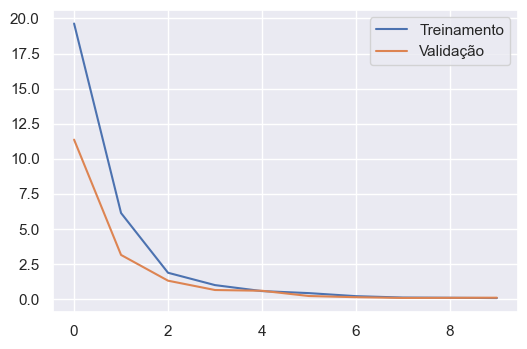

In [50]:
sns.set()

plt.figure(dpi=100)
sns.lineplot(x=range(len(training_loss_for_plot)), y=training_loss_for_plot)
sns.lineplot(x=range(len(valid_loss_for_plot)), y=valid_loss_for_plot)
plt.legend(["Treinamento", "Validação"])

Vamos agora salvar nosso modelo para caso desejemos o utilizar futuramente.

In [68]:
torch.save(siam_model.state_dict(), "./SiameseModelWeights.pt")

## Resultados

Para validar o modelo de uma forma mais desafiadora, será inicialmente validado no conjunto de validação e em seguida em um conjunto separado de outro dataset disponível no Kaggle [neste endereço](https://www.kaggle.com/divyanshrai/handwritten-signatures).

### Conjutno de Validação

Vamos observar os resultados para alguns conjuntos de validação.

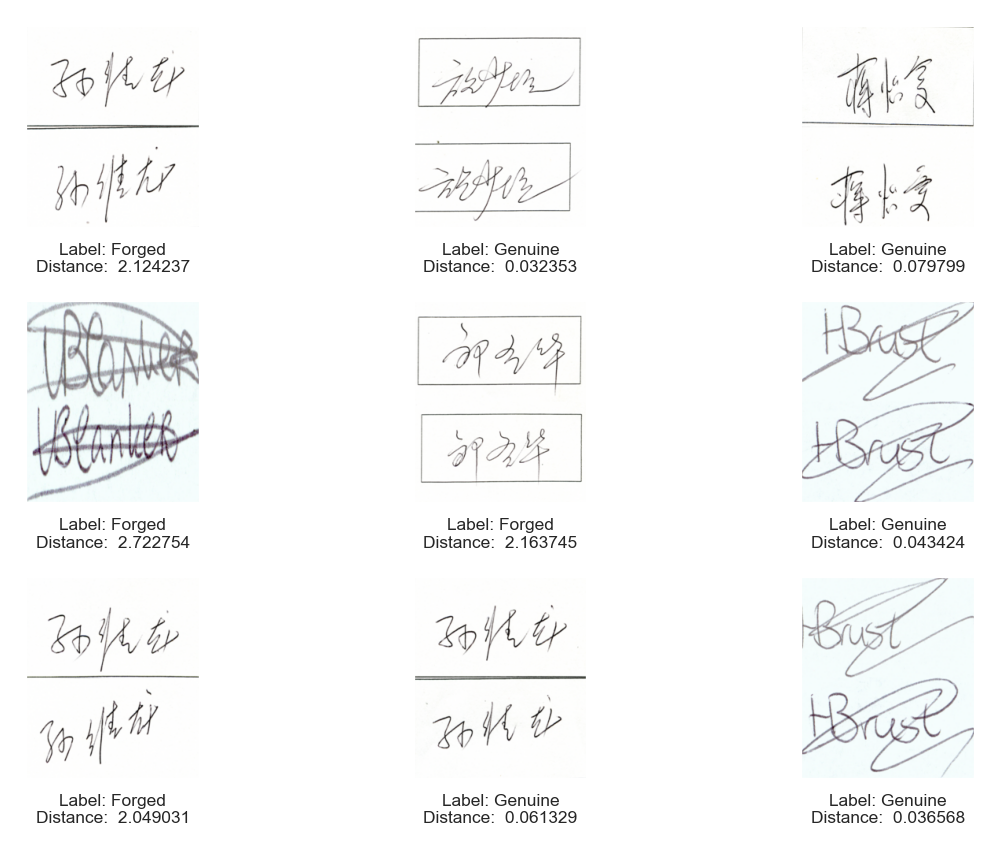

In [92]:
# Criamos um subplot para observar vários exemplos de uma vez
fig, ax = plt.subplots(3, 3, dpi=250)
plt.subplots_adjust(wspace=0.0, hspace=0.35)

siam_model.cpu().eval()
truth_dict = {1: "Genuine", 0: "Forged"}

valid_idxs = [item.item() for item in random.choices(test_idxs, k=9)]

i = 0
j = 0
for idx in valid_idxs:
    img1 = transforms.functional.to_pil_image(dataset[idx][0]).resize((224,130))
    img2 = transforms.functional.to_pil_image(dataset[idx][1]).resize((224,130))
    label = truth_dict[int(dataset[idx][2].item())]
    
    img_concat = concat_img_v(img1, img2)
    if j % 3 == 0 and j != 0:
        j = 0
        i += 1
    ax[i][j].imshow(img_concat)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    with torch.no_grad():
        distance = siam_model(dataset[idx][0].unsqueeze(0), dataset[idx][1].unsqueeze(0))
    ax[i][j].set_xlabel(f"Label: {label}\nDistance: {distance.item() : .6f}", fontsize=5)
    j += 1

Podemos observar claramente que as assinaturas genuínas tendem a estarem próximas, enquanto as assinaturas forjadas tendem a permanecer longe. Vamos agora testar no dataset totalmente diferente de forma que eliminemos completamente algum *leaking* que tenha ocorrido para o treinamento.

## Dataset Diferente

In [249]:
forged_path =  Path(".\sample_Signature\sample_Signature/forged")
genuine_path = Path(".\sample_Signature\sample_Signature\genuine")

In [250]:
all_forged_imgs = list(forged_path.glob("*.png"))
all_genuine_imgs = list(genuine_path.glob("*.png"))

Novamente, buscamos 9 assinaturas reais e buscaremos suas correspondentes forjadas.

In [257]:
# Queremos 9 assinaturas reais como base
genuine_authors = [f"00{i}" for i in range(1,10)]
checklist = []
genuine_example_paths = []
for gim in all_genuine_imgs:
    if (gim.stem[-3:] in genuine_authors) and (gim.stem[-3:] not in checklist):
        genuine_example_paths.append(gim)
        checklist.append(gim.stem[-3:])

# Obtemos então aleatoriamente uma assinatura valida ou uma assinatura forjada
all_imgs = all_forged_imgs.copy()
all_imgs.extend(all_genuine_imgs)
any_images = list(filter(lambda x: x.stem[-3:] in genuine_authors, all_imgs))

random_example_paths = []
for author in genuine_authors:
    random_choice = random.choice(list(filter(lambda x: x.stem[-3:] == author and (x not in genuine_example_paths), any_images)))
    random_example_paths.append(random_choice)

genuine_example_paths[:3], random_example_paths[:3]

([WindowsPath('sample_Signature/sample_Signature/genuine/NFI-00101001.png'),
  WindowsPath('sample_Signature/sample_Signature/genuine/NFI-00201002.png'),
  WindowsPath('sample_Signature/sample_Signature/genuine/NFI-00301003.png')],
 [WindowsPath('sample_Signature/sample_Signature/forged/NFI-00301001.png'),
  WindowsPath('sample_Signature/sample_Signature/genuine/NFI-00204002.png'),
  WindowsPath('sample_Signature/sample_Signature/genuine/NFI-00302003.png')])

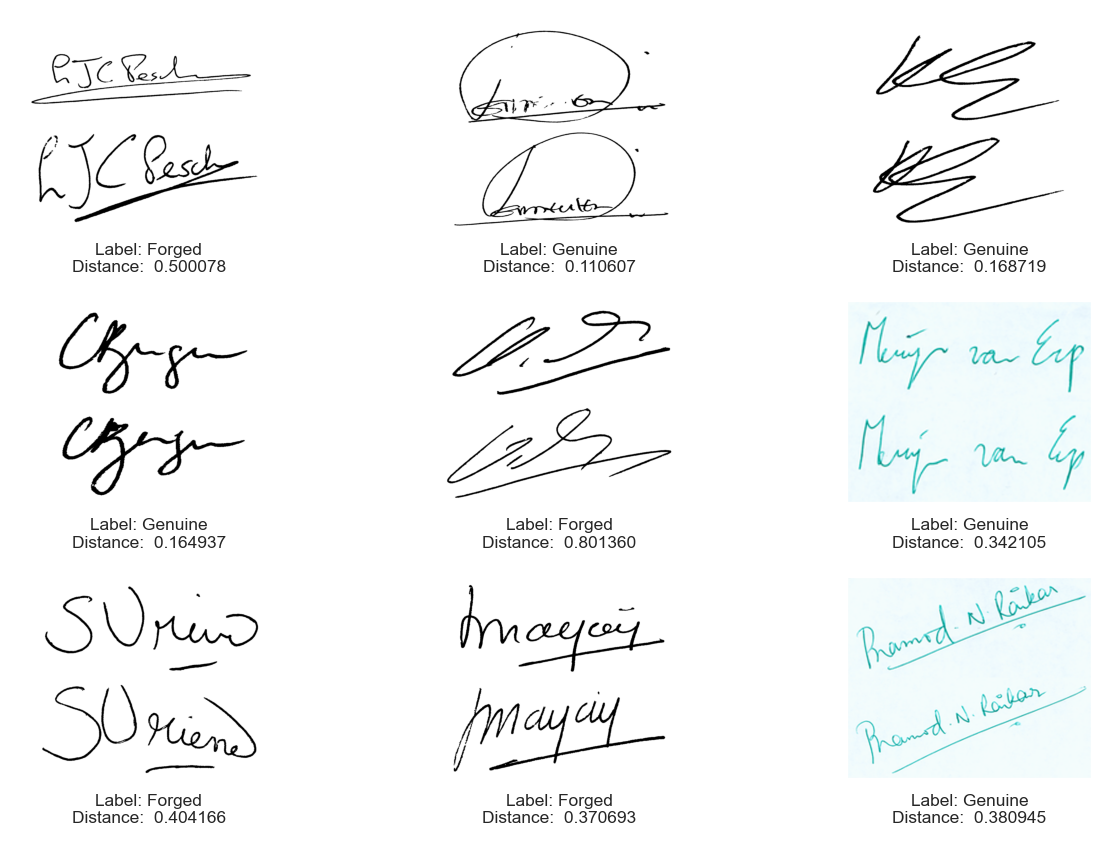

In [258]:
# Criamos um subplot para observar vários exemplos de uma vez
fig, ax = plt.subplots(3, 3, dpi=250)
plt.subplots_adjust(wspace=0.2, hspace=0.35)

siam_model.cpu().eval()
truth_dict = {1: "Genuine", 0: "Forged"}

i = 0
j = 0
for writerID in range(0,9):
    img1 = get_img(genuine_example_paths[writerID])
    img2 = get_img(random_example_paths[writerID])
    img1_tensor = transform(img1)
    img2_tensor = transform(img2)
    img_concat = concat_img_v(img1, img2)
    if j % 3 == 0 and j != 0:
        j = 0
        i += 1
    ax[i][j].imshow(img_concat)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    
    name = random_example_paths[writerID].stem
    name = "Genuine" if name.split("-")[1][:3] == name[-3:] else "Forged"
    
    with torch.no_grad():
        distance = siam_model(img1_tensor.unsqueeze(0), img2_tensor.unsqueeze(0))
        
    ax[i][j].set_xlabel(f"Label: {name}\nDistance: {distance.item(): .6f}", fontsize=5)
    j += 1

Podemos observar que a distância ainda permanece menor para as assinaturas genuínas, o que é um ótimo sinal! Porém, para este dataset, é possível observar algumas forjas permanecendo a uma distância próxima da assinatura real, na região das distâncias que caracterizam uma assinatura genuína. Algumas melhorias podem ser realizadas neste caso:

- Aumentar o tamanho do nosso dataset seria um ótimo ponto de partida haja vista que seu tamanho em quantidade de imagens originais era pequeno. O que o tornou grande foi a grande quantidade de combinações possíveis que foi realizada.
- Mudar a Loss Function para uma `Triplet Loss`, onde uma imagem âncora receberia juntamente uma imagem positiva e uma imagem negativa. A convergência e a capacidade preditiva de redes treinadas dessa forma é maior que para redes treinadas utilizando a `Contrastive Loss`. Como exemplo, temos a Facenet da Google que utilizou esta função de custo para treinar redes que geram embedding utilizados para o reconhecimento facial.
- Utilizar uma rede com mais camadas, de forma que sua capacidade preditiva seja mais robusta.